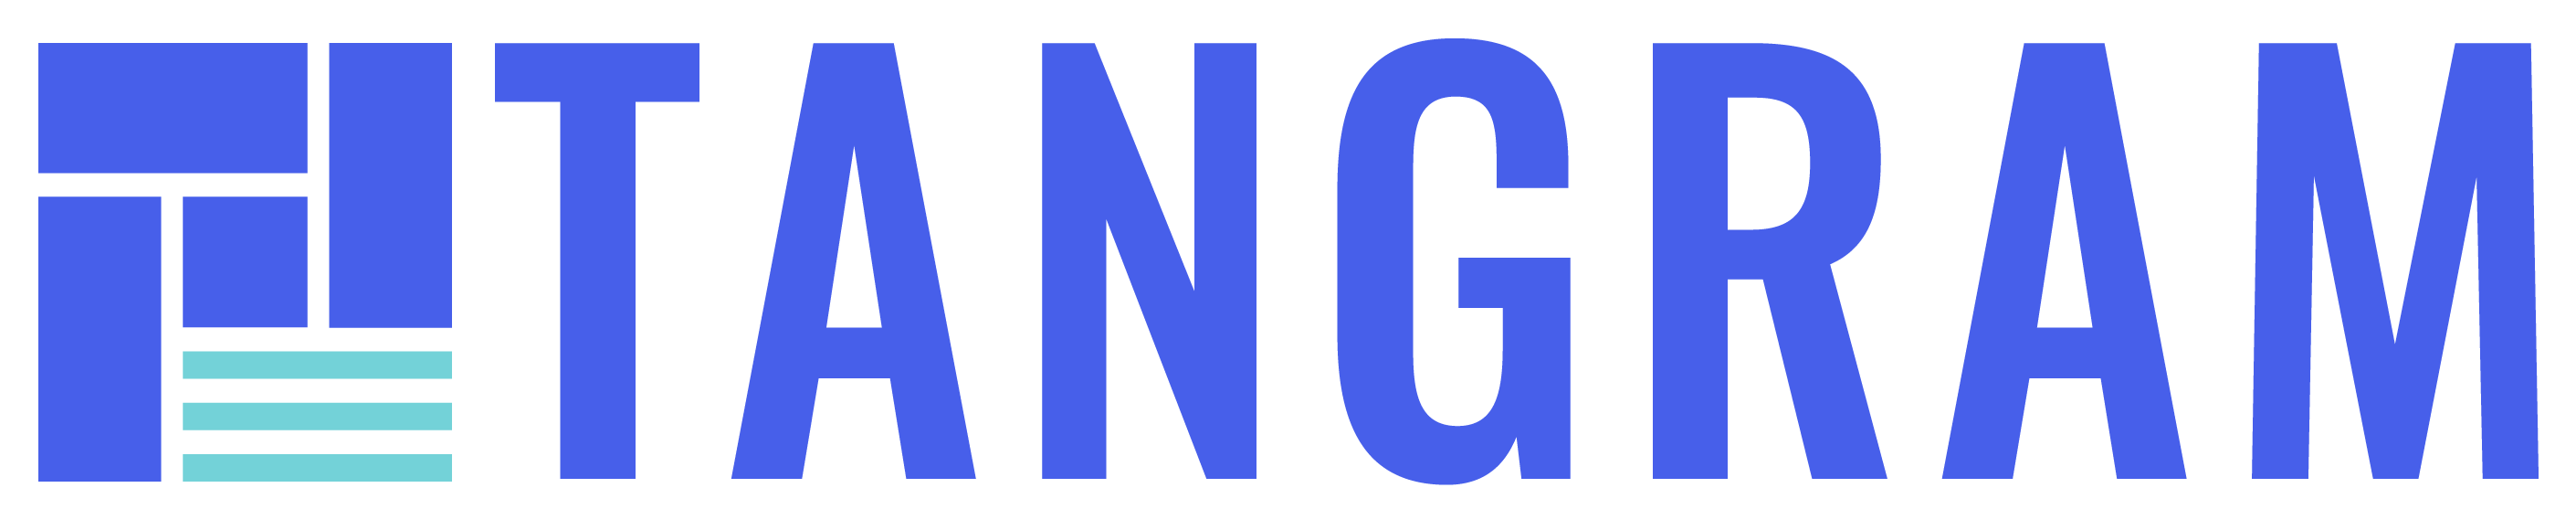

# Hands-on session on spatial mapping using Tangram

## Task 2: Imputation on mouse fetal liver MERFISH data

High-resolution targeted spatial transcriptomics technologies (e.g., MERFISH) are limited in their gene throughput. 
If we are interested in whole-transcriptome high-resolution spatial data, *Tangram* provides a solution for this problem by imputing spatial expression of genes that were not measured in space, using single-cell or single-nucleus expression data. 

This exercise focuses on the imputation use case of *Tangram* and is inspired by https://www.sc-best-practices.org/spatial/imputation.html.

### Setting up

In [ ]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

datadir = '../../datasets/Hands_on_4_Tangram/Task_2/'

In [ ]:
adata_sc = sc.read_h5ad(os.path.join(datadir, 'lu_scRNA_mouse_fetal_liver_pp.h5ad'))
sc.pl.umap(adata_sc, color="leiden")

In [ ]:
adata_st = sc.read_h5ad(os.path.join(datadir, 'lu_merfish_mouse_fetal_liver_2021.h5ad'))

A field of view (FOV) refers to a specific region of the tissue. 

In [ ]:
adata_st.obs["FOV"].value_counts()

In [ ]:
adata_st.obs

In [ ]:
sc.pl.spatial(adata_st[adata_st.obs["FOV"] == 0,:], color="cell_type", spot_size=20)

### Common gene set between reference and spatial dataset

We want to select our training genes. These genes are shared between the two datasets and should capture the biological variance between cell types. In this case, the MERFISH dataset only has 132 genes (also this is why we want to do imputation) so we use all of them. 

In [ ]:
markers = list(set.intersection(set(adata_sc.var_names), set(adata_st.var_names)))
len(markers)

**Task**: From Task 1 you already know `tg.pp_adatas`. Us is to preprocess the mouse liver datasets. 

In [ ]:
# XXX

You can check if you did it right:

In [ ]:
assert "training_genes" in adata_sc.uns
assert "training_genes" in adata_st.uns

print(f"Number of training_genes: {len(adata_sc.uns['training_genes'])}")

### Computing the map from single-cells to spatial voxels

Having specified the training genes, we can now create the map from dissociated single-cell measurements to the spatial locations. As you know by now, this is done with `map_cells_to_space` function. This function has two different modes, `mode='cells'` and `mode='clusters'`. The latter only maps averaged single-cells which makes the mapping computationally faster and more robust when mapping between specimen. However, as we are interested in imputing our spatial data, we need the cell mode now, which requires access to a GPU for reasonable runtime. This is why we did aleady run this code for you:



```python
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="cells",
    density_prior="rna_count_based",
    num_epochs=500,
    device="cuda",
)
ad_map.write_h5ad(os.path.join(datadir, 'tangram_mapped_mouse_fetal_liver.h5ad'))
```



The resulting `ad_map` is itself an AnnData object. You can load it like this:

In [ ]:
ad_map = sc.read_h5ad(os.path.join(datadir, 'tangram_mapped_mouse_fetal_liver.h5ad'))
# also copy the leiden clustering annotation to the new adata
ad_map.obs = adata_sc.obs.copy()

In [ ]:
ad_map

### Imputing genes and mapping cell-types to space

We can use this result in two ways. First, we can map the cell type information that was originally only present in the single-cell data to space. This an easy way to check that your results are biologically consistent by looking for known cell type patterns. Second, we can investigate the spatial gene-expression of those genes that have not been measured with the in-situ method in the first place, effectively imputing all the missing genes.

**Task**: Project the cell annotation (obs column `leiden`) to spatial locations

In [ ]:
# XXX

**Task**: Plot the spatial celltype annotation for the FOV 0.

<div style="
    background-color: #e6f3ff;
    border-left: 4px solid #2196F3;
    padding: 10px 15px;
    border-radius: 5px;
    margin: 10px 0;
">
<b>💡 Hint:</b> The <code>perc</code> argument steers the range of the colourmap and can help with removing outliers.
</div>


In [ ]:
# XXX

**Task**: To get a deeper sense, plot the sparsity scores for the training genes. You know the function already!

In [ ]:
# XXX

The score generally measures the similarity between original measurement (by the spatial technology) and the inferred mapping by single-cell data. The middle panels both relate the sparsity of the respective data, single-cell and spatial, of a training genes (each dot is a training gene) with the achieved score. As you can see, the performance is much more correlated with the spatial data which is often more sparse and therefore responsible for low-quality mappings. The last panel sets both technologies in context. Genes that have similar sparsity levels in both spatial and single-cell data usually achieve better scores than those that are inconsistent across technologies.

Minor remark: The similarity that Tangram builds on is cosine similarity.

Even more detailed information can be found in the `.uns["train_genes_df"]`.

Now, we can project the genes present in the single-cell data to the spatial locations. This is easily achieved by multiplying the mapping matrix stored in `ad_map` with the original single-cell data stored in `adata_sc`. Tangram already provides a convenience function which takes in a mapping and the corresponding single-cell data. The result is a spatial voxel by genes matrix which technically is identical to the original spatial data `adata_st` but contains expression values for all genes.

**Task**: Project the gene expression to voxels.

In [ ]:
# XXX

If this takes too long, you can also read the precomputed data:

In [ ]:
ad_ge = sc.read_h5ad(os.path.join(datadir, 'ad_ge_tangram_2.h5ad'))

Next, we will compare the new spatial data with the original measurements. This will provide us with a better feeling why some training scores might be bad. Note that this explicit mapping of Tangram relies on entirely different premises than those in probabilistic models. Here, we are inclined to trust the predicted gene expression patterns based on the good mapping performance of most training genes. The fact the some genes show a very sparse and dispersed spatial signal can be understood a result of technical dropout of the spatial technology rather than a shortcoming of the mapping method.

In [ ]:
genes = ["tek", "stab2", "hc"]
ad_map.uns["train_genes_df"].loc[genes]

**Task**: Plot the new spatial data next to the original spatial expression with the Tangram function that you already know. 

In [ ]:
# XXX

### Plotting genes that were not part of the training data

We can also inspect genes there were part of the training genes but not detected in the spatial data.

**Task**: Repeat the last task with the genes "rp1", "sox17", and "mrpl15".

In [ ]:
# XXX

As we can see, Tangram projected the additional features onto space and we have now access to all additional genes and their estimated value at each spatial coordinate.